![](../images/featuretools.png)

# Predicting Loan Repayment with Automated Feature Engineering in Featuretools

Feature engineering is the process of creating new features (also called predictors or explanatory variables) out of an existing dataset. Traditionally, this process is done by hand using domain knowledge to build new features one at a time. Feature engineering is crucial for a data science problem and a manual approach is time-consuming, tedious, error-prone, and must be re-done for each problem. Automated feature engineering aims to aid the data scientist in this critical process by automatically creating hundreds or thousands of new features from a set of related tables in a fraction of the time as the manual approach. In this notebook, we will apply automated feature engineering to the Home Credit Default Risk loan dataset using [Featuretools, an open-source Python library](https://featuretools.alteryx.com/) for automated feature engineering. 

This problem is a machine learning competition on Kaggle where the objective is to predict if an applicant will default on a loan given comprehensive data on past loans and applicants. The data is spread across seven different tables making this an ideal problem for automated feature engineering: all of the data must be gathered into a single dataframe for training (and one for testing) with the aim of capturing as much usable information for the prediction problem as possible. As we will see, featuretools can efficiently carry out the tedious process of using all of these tables to make new features with only a few lines of code. Moreover, this code is generally applicable to any data science problem! 


## Approach 

In this notebook, we will implement an automated feature engineering approach to the loan repayment problem. While Featuretools allows plenty of options for customization of the library to improve accuracy, we'll focus on a fairly high-level implementation.

Our approach will be as follows with the background covered as we go:

1. Read in the set of related data tables
2. Create a featuretools `EntitySet` and add `dataframes` to it 
    * Identify correct column types as required
    * Identify indices in data
3. Add relationships between `dataframes`
4. Select feature primitives to use to create new features
    * Use basic set of primitives
    * Examine features that will be created
5. Run Deep Feature Synthesis to generate thousands of new features


## Problem and Dataset

The [Home Credit Default Risk competition](https://www.kaggle.com/c/home-credit-default-risk) currently running on Kaggle is a supervised classification task where the objective is to predict whether or not an applicant for a loan (known as a client) will default on the loan. The data comprises socio-economic indicators for the clients, loan specific financial information, and comprehensive data on previous loans at Home Credit (the institution sponsoring the competition) and other credit agencies. The metric for this competition is Receiver Operating Characteristic Area Under the Curve (ROC AUC) with predictions made in terms of the probability of default. We can evaluate our submissions both through cross-validation on the training data (for which we have the labels) or by submitting our test predictions to Kaggle to see where we place on the public leaderboard (which is calculated with only 10% of the testing data). 

The Home Credit Default Risk dataset ([available for download here](https://www.kaggle.com/c/home-credit-default-risk/data)) consists of seven related tables of data:

* application_train/application_test: the main training/testing data for each client at Home Credit. The information includes both socioeconomic indicators for the client and loan-specific characteristics. Each loan has its own row and is uniquely identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions (not Home Credit). Each previous credit has its own row in bureau, but one client in the application data can have multiple previous credits. The previous credits are uniquely identified by the feature `SK_ID_BUREAU`.
* bureau_balance: monthly balance data about the credits in bureau. Each row has information for one month about a previous credit and a single previous credit can have multiple rows. This is linked backed to the bureau loan data by `SK_ID_BUREAU` (not unique in this dataframe).
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each client in the application data can have multiple previous loans. Each previous application has one row in this dataframe and is uniquely identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans from the previous loan data. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* credit_card_balance: monthly data about previous credit cards loans from the previous loan data. Each row is one month of a credit card balance, and a single credit card can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).


The columns that tie the tables together will be important to understand when it comes to adding `relationships` between dataframes. __The only domain knowledge we need for a full Featuretools approach to the problem is the indexes of the tables and the relationships between the tables.__

To run this notebook, download the data from the link above and place the files a folder called `input`.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# suppress warnings
import warnings
warnings.simplefilter("ignore")

/Users/nate.parsons/dev/open_source_demos/env/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Read in Data

First we can read in the seven data tables. We also replace the anomalous values previously identified.

In [2]:
# Read in the datasets and replace the anomalous values
app_train = pd.read_csv('input/application_train.csv').replace({365243: np.nan})
app_test = pd.read_csv('input/application_test.csv').replace({365243: np.nan})
bureau = pd.read_csv('input/bureau.csv').replace({365243: np.nan})
bureau_balance = pd.read_csv('input/bureau_balance.csv').replace({365243: np.nan})
cash = pd.read_csv('input/POS_CASH_balance.csv').replace({365243: np.nan})
credit = pd.read_csv('input/credit_card_balance.csv').replace({365243: np.nan})
previous = pd.read_csv('input/previous_application.csv').replace({365243: np.nan})
installments = pd.read_csv('input/installments_payments.csv').replace({365243: np.nan})

We will join together the training and testing datasets to make sure we build the same features for each set. Later, after the feature matrix is built, we can separate out the two sets. 

In [3]:
app_test['TARGET'] = np.nan

# Join together training and testing
app = app_train.append(app_test, ignore_index = True, sort = True)

Several of the indexes are an incorrect data type (floats) so we need to make these all the same (integers) for adding relationships. 

In [4]:
for index in ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']:
    for dataset in [app, bureau, bureau_balance, cash, credit, previous, installments]:
        if index in list(dataset.columns):
            dataset[index] = dataset[index].fillna(0).astype(np.int64)

# Featuretools Basics

[Featuretools](https://featuretools.alteryx.com/) is an open-source Python library for automatically creating features out of a set of related tables using a technique called Deep Feature Synthesis. Automated feature engineering, like many topics in machine learning, is a complex subject built upon a foundation of simpler ideas. By going through these ideas one at a time, we can build up our understanding of Featuretools which will later allow for us to get the most out of it.

There are a few concepts that we will cover along the way:

* [Representing Data with EntitySets](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html): our tables and a data structure for keeping track of them all
* [Relationships between tables](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html#Adding-a-Relationship): how the tables can be related to one another
* [Feature primitives](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html): aggregations and transformations that are stacked to build features
* [Deep feature synthesis](https://featuretools.alteryx.com/en/stable/getting_started/afe.html): the method that uses feature primitives to generate thousands of new features

# Dataframes and Entitysets

A dataframe is simply a table of data. The observations must be in the rows and the features in the columns. A dataframe used in Featuretools must have a unique index where none of the elements are duplicated.  Currently, only `app`, `bureau`, and `previous` have unique indices (`SK_ID_CURR`, `SK_ID_BUREAU`, and `SK_ID_PREV` respectively). For the other dataframes, when we add them to an entityset, we must pass in `make_index = True` and then specify the name of the index. 

Dataframes can also have time indices that represent when the information in the row became known. (There are not datetimes in any of the data, but there are relative times, given in months or days, that could be treated as time variables, although we will not use them as time in this notebook).

An [EntitySet](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html) is a collection of tables and the relationships between them. This can be thought of a data structure with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and will make creating the features much simpler than keeping track of individual tables and relationships. __EntitySets is an abstraction that can be applied to any dataset because id do not depend on the underlying data.__

First we'll make an empty entityset named clients to keep track of all the data.

In [5]:
# Entityset with id applications
es = ft.EntitySet(id = 'clients')

### Column Data Types

Featuretools will automatically infer the column data types. However, there may be some cases where we need to explicitly tell Featuretools the column type such as when a boolean column is represented as an integer. Column types in Featuretools can be specified as a dictionary of [Woodwork logical types](https://woodwork.alteryx.com/en/stable/guides/logical_types_and_semantic_tags.html). 

We will first work with the `app` data to specify the proper column types. To identify the `Boolean` columns that are recorded as numbers (1.0 or 0.0), we can iterate through the data and find any columns where there are only 2 unique values and the data type is numeric. We can also use the column definitions to find any other data types that should be identified, such as `Ordinal` columns. Identifying the correct types is important because Featuretools applies different operations to different data types (just as we do when manual feature engineering).

In [6]:
app_types = {}

# Handle the Boolean columns:
for col in app.columns:
    if (app[col].nunique() == 2) and (app[col].dtype == float or app[col].dtype == int):
        app_types[col] = 'Boolean'

# Remove the `TARGET`
del app_types['TARGET']

print('There are {} Boolean columns in the application data.'.format(len(app_types)))

There are 32 Boolean columns in the application data.


In [7]:
# Ordinal columns - must be specified as a Woodwork `Ordinal`
# logical type with order values specified

from woodwork.logical_types import Ordinal

app_types['REGION_RATING_CLIENT'] = Ordinal(order=[1, 2, 3])
app_types['REGION_RATING_CLIENT_W_CITY'] = Ordinal(order=[-1, 1, 2, 3])
app_types['HOUR_APPR_PROCESS_START'] = Ordinal(order=list(range(0,24)))

The `previous` table is the only other `dataframe` that has features which should be recorded as Boolean. Correctly identifying the type of column will prevent Featuretools from making irrelevant features such as the mean or max of a `Boolean`. 

In [8]:
previous_types = {}

# Handle the Boolean columns:
for col in previous:
    if (previous[col].nunique() == 2) and (previous[col].dtype == float or previous[col].dtype == int):
        previous_types[col] = 'Boolean'

print('There are {} Boolean columns in the previous data.'.format(len(previous_types)))

There are 2 Boolean columns in the previous data.


In addition to identifying Boolean columns, we want to make sure Featuretools does not create nonsense features such as statistical aggregations (mean, max, etc.) of ids. The `credit`, `cash`, and `installments` data all have the `SK_ID_CURR` column. However, we do not actually need this column in these dataframes because we link them to `app` through the `previous` dataframe with the `SK_ID_PREV` column. 

We don't want to make features from `SK_ID_CURR` since it is an arbitrary id and should have no predictive power. 
Our options to handle these columns is either to tell Featuretools to ignore them, or to drop the features before including them in the entityset. We will take the latter approach.

In [9]:
installments = installments.drop(columns = ['SK_ID_CURR'])
credit = credit.drop(columns = ['SK_ID_CURR'])
cash = cash.drop(columns = ['SK_ID_CURR'])

## Adding DataFrames to the EntitySet

Now we define each table of data and add it to the `EntitySet`. We need to pass in an index if the table has one or `make_index = True` if not. In the cases where we need to make an index, we must supply a name for the index. We also need to pass in the dictionary of column logical types if there are any specific columns we should identify. The following code adds all seven tables to the `EntitySet`.

In [10]:
# Dataframes with a unique index
es = es.add_dataframe(dataframe_name='app', dataframe=app, index='SK_ID_CURR',
                      logical_types=app_types)

es = es.add_dataframe(dataframe_name='bureau', dataframe=bureau, index='SK_ID_BUREAU')

es = es.add_dataframe(dataframe_name='previous', dataframe=previous, index='SK_ID_PREV',
                      logical_types=previous_types)

# Dataframes that do not have a unique index
es = es.add_dataframe(dataframe_name='bureau_balance', dataframe=bureau_balance,
                      make_index=True, index='bureaubalance_index')

es = es.add_dataframe(dataframe_name='cash', dataframe=cash, 
                      make_index=True, index='cash_index')

es = es.add_dataframe(dataframe_name='installments', dataframe=installments,
                      make_index=True, index='installments_index')

es = es.add_dataframe(dataframe_name='credit', dataframe=credit,
                      make_index=True, index='credit_index')

In [11]:
# Display entityset so far
es

Entityset: clients
  DataFrames:
    app [Rows: 356255, Columns: 122]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 8]
    installments [Rows: 13605401, Columns: 8]
    credit [Rows: 3840312, Columns: 23]
  Relationships:
    No relationships

The `EntitySet` allows us to group together all of our tables as one data structure. This is much easier than manipulating the tables one at a time (as we have to do in manual feature engineering).

# Relationships

Relationships are a fundamental concept not only in featuretools, but in any relational database. The most common type of relationship is one-to-many. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. In the context of tables, a parent table will have one row (observation) for every individual while a child table can have many observations for each parent.  In a _parent table_, each individual has a single row and is uniquely identified by an index (also called a key). Each individual in the parent table can have multiple rows in the _child table_. Things get a little more complicated because children tables can have children of their own, making these grandchildren of the original parent. 

As an example of a parent-to-child relationship, the `app` dataframe has one row for each client (identified by `SK_ID_CURR`) while the `bureau` dataframe has multiple previous loans for each client. Therefore, the `bureau` dataframe is the child of the `app` dataframe. The `bureau` dataframe in turn is the parent of `bureau_balance` because each loan has one row in `bureau` (identified by `SK_ID_BUREAU`) but multiple monthly records in `bureau_balance`. When we do manual feature engineering, keeping track of all these relationships is a massive time investment (and a potential source of error), but we can add these relationships to our `EntitySet` and let featuretools worry about keeping the tables straight!

In [12]:
print('Parent: app, Parent Column of bureau: SK_ID_CURR\n\n', app.iloc[99350:99360, :4])
print('\nChild: bureau, Child Column of app: SK_ID_CURR\n\n', bureau.iloc[:, :5].head())

Parent: app, Parent Column of bureau: SK_ID_CURR

         AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL
215347      11488.5    225000.0         225000.0          202500.0
215349      47961.0    445333.5         423000.0          225000.0
215350      32602.5    675000.0         675000.0           81000.0
215352      36927.0    835380.0         675000.0          270000.0
215353      10291.5    182016.0         144000.0          157500.0
215354      21181.5    720000.0         720000.0          270000.0
215355      12406.5    405000.0         405000.0           67500.0
215356       6430.5    170640.0         135000.0           60750.0
215357      37017.0   1026922.5         886500.0          157500.0
215359      40320.0    835380.0         675000.0          225000.0

Child: bureau, Child Column of app: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT
5714462      215354       5714462        Closed      currency 1         -497
5714463 

The `SK_ID_CURR` 215354 has one row in the parent table and multiple rows in the child. 

Two tables are linked via a shared column. The `app` and `bureau` dataframe are linked by the `SK_ID_CURR` column while the `bureau` and `bureau_balance` dataframes are linked with the `SK_ID_BUREAU`. The linking column is called the `parent` columns in the parent table and the `child` column in the child table.

In [13]:
print('Parent: bureau, Parent Column of bureau_balance: SK_ID_BUREAU\n\n', bureau.iloc[:, :5].head())
print('\nChild: bureau_balance, Child Column of bureau: SK_ID_BUREAU\n\n', bureau_balance.head())

Parent: bureau, Parent Column of bureau_balance: SK_ID_BUREAU

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT
5714462      215354       5714462        Closed      currency 1         -497
5714463      215354       5714463        Active      currency 1         -208
5714464      215354       5714464        Active      currency 1         -203
5714465      215354       5714465        Active      currency 1         -203
5714466      215354       5714466        Active      currency 1         -629

Child: bureau_balance, Child Column of bureau: SK_ID_BUREAU

    bureaubalance_index  SK_ID_BUREAU  MONTHS_BALANCE STATUS
0                    0       5715448               0      C
1                    1       5715448              -1      C
2                    2       5715448              -2      C
3                    3       5715448              -3      C
4                    4       5715448              -4      C


Traditionally, we use the relationships between parents and children to aggregate data by grouping together all the children for a single parent and calculating statistics. For example, we might group together all the loans for a single client and calculate the average loan amount. This is straightforward, but can grow extremely tedious when we want to make hundreds of these features. Doing so one at a time is extremely inefficient especially because we end up re-writing much of the code over and over again and this code cannot be used for any different problem! 

Things get even worse when we have to aggregate the grandchildren because we have to use two steps: first aggregate at the parent level, and then at the grandparent level. Soon we will see that Featuretools can do this work automatically for us, generating thousands of features from __all__ of the data tables. When we did this manually it took about 15 minutes per feature so Featuretools potentially saves us hundreds of hours.

### Adding Relationships

Defining the relationships is straightforward using the diagram for the data tables. For each relationship, we need to specify the entityset, the parent table name, the parent column, the child table name and finally the child column. Altogether, there are a total of 6 relationships between the tables (counting the training and testing relationships as one). Below we specify these relationships and then add them to the EntitySet.

In [14]:
# Relationship between app_train and bureau
r_app_bureau = ft.Relationship(es, 'app', 'SK_ID_CURR', 'bureau', 'SK_ID_CURR')

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es, 'bureau', 'SK_ID_BUREAU', 'bureau_balance', 'SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es, 'app', 'SK_ID_CURR', 'previous', 'SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'cash', 'SK_ID_PREV')
r_previous_installments = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'installments', 'SK_ID_PREV')
r_previous_credit = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'credit', 'SK_ID_PREV')

In [15]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  DataFrames:
    app [Rows: 356255, Columns: 122]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash [Rows: 10001358, Columns: 8]
    installments [Rows: 13605401, Columns: 8]
    credit [Rows: 3840312, Columns: 23]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

Again, we can see the benefits of using an `EntitySet` that is able to track all of the relationships for us. This allows us to work at a higher level of abstraction, thinking about the entire dataset rather than each individual table, greatly increasing our efficiency.

__Slightly advanced note__: we need to be careful to not create a [diamond graph](https://en.wikipedia.org/wiki/Diamond_graph) where there are multiple paths from a parent to a child. If we directly link `app` and `cash` via `SK_ID_CURR`; `previous` and `cash` via `SK_ID_PREV`; and `app` and `previous` via `SK_ID_CURR`, then we have created two paths from `app` to `cash`. This results in ambiguity, so the approach we have to take instead is to link `app` to `cash` through `previous`. We establish a relationship between `previous` (the parent) and `cash` (the child) using `SK_ID_PREV`. Then we establish a relationship between `app` (the parent) and `previous` (now the child) using `SK_ID_CURR`. Then Featuretools will be able to create features on `app` derived from both `previous` and `cash` by stacking multiple primitives. 

If this doesn't make too much sense, then just remember to only include one path from a parent to any descendents. For example, link a grandparent to a grandchild through the parent instead of directly through a shared column.

All dataframes in the entityset can be linked through these relationships. In theory this allows us to calculate features for any of the dataframes, but in practice, we will only calculate features for the `app` dataframe since that will be used for training/testing. The end outcome will be a dataframe that has one row for each client in `app` with thousands of features for each individual. 

We are almost to the point where we can start creating thousands of features but we still have a few foundational topics to understand. The next building block to cover is feature primitives.

## Visualize EntitySet

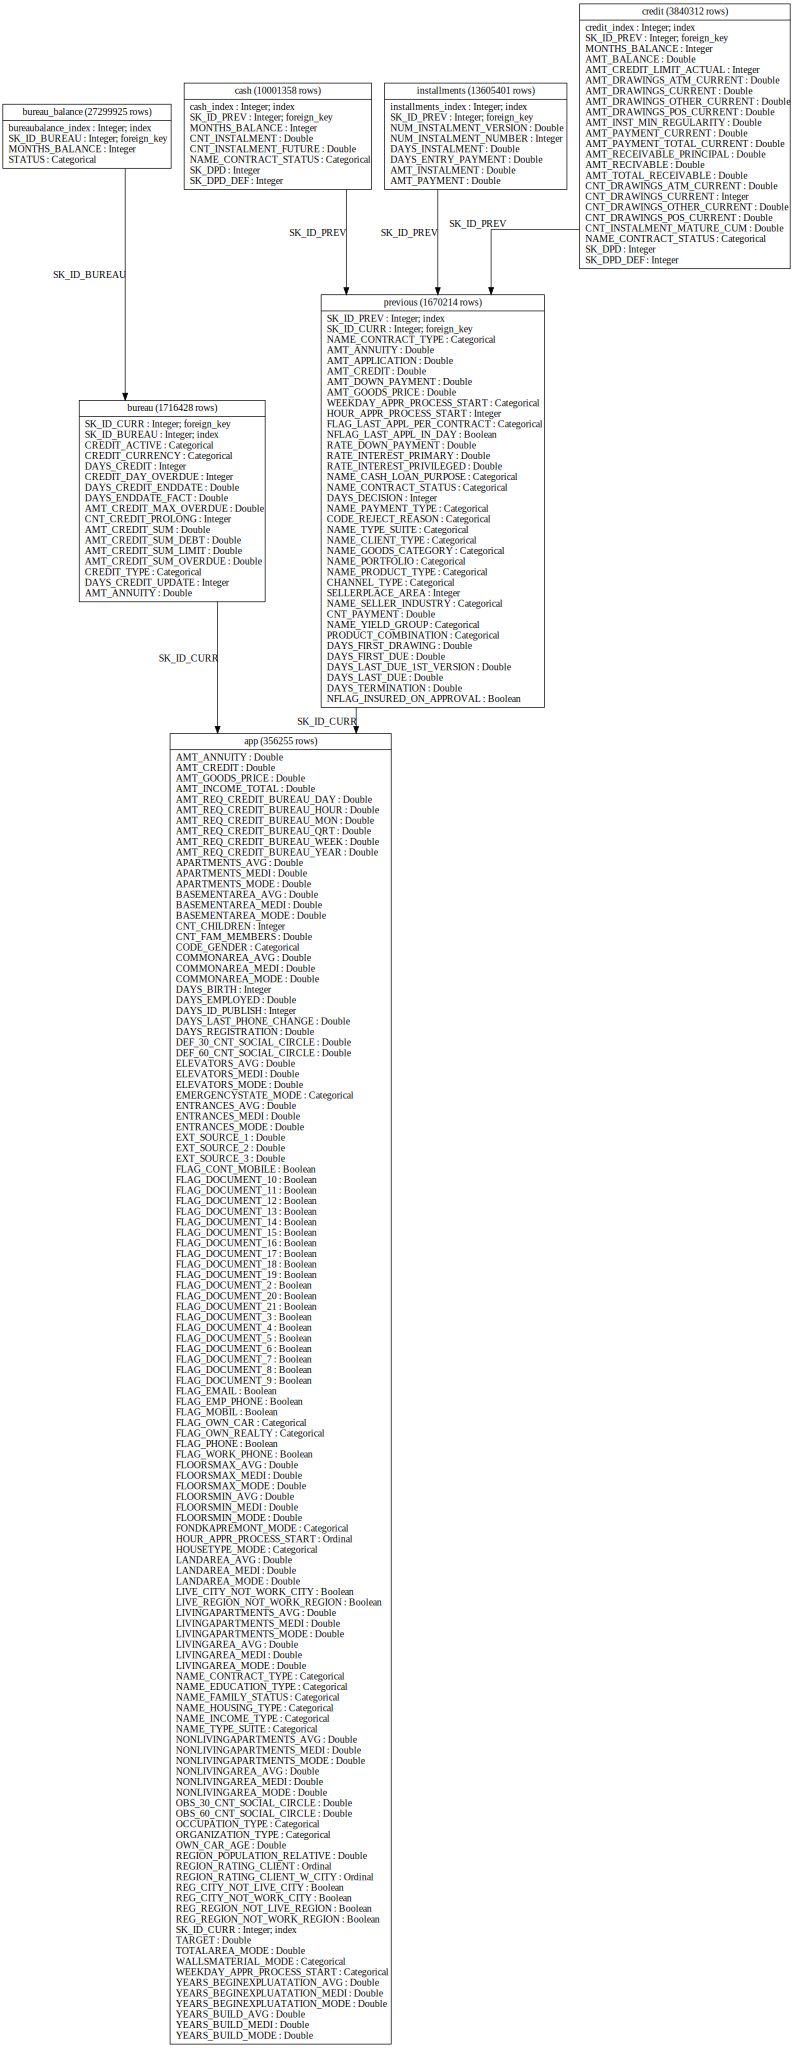

In [16]:
es.plot()

# Feature Primitives

A [feature primitive](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html) is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering, that can be stacked on top of each other to create complex deep features. Feature primitives fall into two categories:

* __Aggregation__: function that groups together children for each parent and calculates a statistic such as mean, min, max, or standard deviation across the children. An example is the maximum previous loan amount for each client. An aggregation covers multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

A list of the available features primitives in featuretools can be viewed below.

In [17]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100

primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,median,aggregation,False,False,Determines the middlemost number in a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
1,avg_time_between,aggregation,False,False,Computes the average number of seconds between consecutive events.,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
2,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
3,num_true,aggregation,True,False,Counts the number of `True` values.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",None
4,trend,aggregation,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...",None
5,entropy,aggregation,False,False,Calculates the entropy for a categorical column,<ColumnSchema (Semantic Tags = ['category'])>,None
6,max,aggregation,True,True,"Calculates the highest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
7,time_since_last,aggregation,False,False,Calculates the time elapsed since the last datetime (default in seconds).,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
8,any,aggregation,True,False,Determines if any value is 'True' in a list.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",None
9,mode,aggregation,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None


In [18]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
22,absolute,transform,True,True,Computes the absolute value of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
23,multiply_numeric_scalar,transform,True,True,Multiply each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
24,or,transform,True,True,Element-wise logical OR of two lists.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",None
25,cityblock_distance,transform,False,False,Calculates the distance between points in a city road grid.,<ColumnSchema (Logical Type = LatLong)>,None
26,cum_sum,transform,False,False,Calculates the cumulative sum.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
27,isin,transform,True,True,Determines whether a value is present in a provided list.,<ColumnSchema>,None
28,modulo_by_feature,transform,True,True,Return the modulo of a scalar by each element in the list.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
29,add_numeric,transform,True,True,Element-wise addition of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
30,age,transform,True,False,Calculates the age in years as a floating point number given a,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['date_of_birth'])>,None
31,equal_scalar,transform,True,True,Determines if values in a list are equal to a given scalar.,<ColumnSchema>,None


# Deep Feature Synthesis

[Deep Feature Synthesis (DFS)](https://featuretools.alteryx.com/en/stable/getting_started/afe.html) is the method Featuretools uses to make new features. DFS stacks feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans (say `MAX(previous.loan_amount)`), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average monthly payments per previous loan (such as `MAX(previous(MEAN(installments.payment)))`). In manual feature engineering, this would require two separate groupings and aggregations and took more than 15 minutes to write the code per feature. 

Deep Feature Synthesis is an extremely powerful method that allows us to overcome our human limitations on time and creativity by building features that we would never be able to think of on our own (or would not have the patience to implement). Furthermore, DFS is applicable to any dataset with only very minor changes in syntax. In feature engineering, we generally apply the same functions to multiple datasets, but when we do it by hand, we have to re-write the code because it is problem-specific. Featuretools code can be applied to any dataset because it is written at a higher level of abstraction.

The [original paper on automated feature engineering using Deep Feature Synthesis](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) is worth a read if you want to understand the concepts at a deeper level.

To perform DFS in featuretools, we use the `dfs`  function passing it an `entityset`, the `target_dataframe_name` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use, the `max_depth` of the features, and a number of other arguments depending on our use case. There are also options for multi-processing with `njobs` and the information that is printed out with `verbose`. 

One other important argument is __`features_only`__. If we set this to `True`, `dfs` will only make the feature names and not calculate the actual values of the features (called the feature matrix). This is useful when we want to inspect the feature that will be created and we can also save the features to use with a different dataset (for example when we have training and testing data).

## Deep Feature Synthesis with Default Primitives

Without using any domain knowledge we can make thousands of features by using the default primitives in featuretools. This first call will use the default aggregation and transformation primitives,  a max depth of 2, and calculate primitives for the `app` dataframe. We will only generate the features themselves (the names and not the values) which we can save and inspect.

In [19]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       where_primitives = [], seed_features = [],
                       max_depth = 2, n_jobs = -1, verbose = 1,
                       features_only=True)

Built 2053 features


Even a basic call to deep feature synthesis gives us over 2000 features to work with. Granted, not all of these will be important, but this still represents hundreds of hours that we saved. Moreover, `dfs` might be able to find important features that we would never have thought of in the first place. 

We can look at the some of the feature names:

In [20]:
feature_names[1000:1020]

[<Feature: MEAN(previous.SUM(credit.CNT_INSTALMENT_MATURE_CUM))>,
 <Feature: MEAN(previous.SUM(credit.MONTHS_BALANCE))>,
 <Feature: MEAN(previous.SUM(credit.SK_DPD))>,
 <Feature: MEAN(previous.SUM(credit.SK_DPD_DEF))>,
 <Feature: MEAN(previous.SUM(installments.AMT_INSTALMENT))>,
 <Feature: MEAN(previous.SUM(installments.AMT_PAYMENT))>,
 <Feature: MEAN(previous.SUM(installments.DAYS_ENTRY_PAYMENT))>,
 <Feature: MEAN(previous.SUM(installments.DAYS_INSTALMENT))>,
 <Feature: MEAN(previous.SUM(installments.NUM_INSTALMENT_NUMBER))>,
 <Feature: MEAN(previous.SUM(installments.NUM_INSTALMENT_VERSION))>,
 <Feature: MIN(previous.COUNT(cash))>,
 <Feature: MIN(previous.COUNT(credit))>,
 <Feature: MIN(previous.COUNT(installments))>,
 <Feature: MIN(previous.MAX(cash.CNT_INSTALMENT))>,
 <Feature: MIN(previous.MAX(cash.CNT_INSTALMENT_FUTURE))>,
 <Feature: MIN(previous.MAX(cash.MONTHS_BALANCE))>,
 <Feature: MIN(previous.MAX(cash.SK_DPD))>,
 <Feature: MIN(previous.MAX(cash.SK_DPD_DEF))>,
 <Feature: MIN(p

Notice how featuretools stacks multiple primitives on top of each other. This one of the ideas behind Deep Feature Synthesis and automated feature engineering. Rather than having to do these groupings and aggregations by ourselves, Featuretools is able to handle it all using the framework (`dataframes`, `relationships`, and `primitives`) that we provide. We can also use Featuretools to expand on our domain knowledge. 

# Building on Top of Domain Features

Featuretools will automatically build thousands of features for us, but that does not mean we can't use our own knowledge to improve the predictive performance. Featuretools is able to augment our domain knowledge by stacking additional features on top of our domain knowledge based features. We identified and created numerous useful features in the manual feature engineering notebook, based on our own knowledge and that of thousands of data scientists working on this problem on Kaggle. Rather than getting only one domain knowledge feature, we can effectively get dozens or even hundreds. __Here we'll explain the options for using domain knowledge, but we'll stick with the simple implementation of Featuretools for comparison purposes.__

For more information on any of these topics, see the [documentation](https://featuretools.alteryx.com/en/stable/guides/tuning_dfs.html) or the other notebooks in this repository. 

### Seed Features 

Seed features are domain features that we make in the data that Featuretools is then able to build on top of. For example, we saw that the rate of a loan is an important feature because a higher rate loan is likely more risky. In Featuretools, we can encode the loan rate (both for the current loan and for previous loans) as a seed feature and Featuretools will build additional explanatory variables on this domain knowledge wherever possible. 

### Interesting Values

Interesting values have a similar idea to seed features except they allow us to make conditional features. For example, we might want to find for each client the mean amount of previous loans that have been closed and the mean amount of previous loans that are still active. By specifying interesting values in `bureau` on the `CREDIT_ACTIVE` column we can have Featuretools do exactly that! Carrying this out by hand would be extremely tedious and present numerous opportunities for errors.

### Custom Primitives

If we aren't satisfied with the primitives available to use in Featuretools, we can write our own functions to transform or aggregate the data. This is one of the most powerful capabilities in featuretools because it allows us to make very specific operations that can then be applied to multiple datasets. 

__In this notebook we concentrate on a basic implementation of Featuretools, but keep in mind these capabilities are available for optimizing the library and using domain knowledge!__

# Selecting Primitives

For our actual set of features, we will use a select group of primitives rather than just the defaults. This will generate over 1600 features to use for modeling. 

In [21]:
# Specify primitives
agg_primitives =  ["sum", "max", "min", "mean", "count", "percent_true", "num_unique", "mode"]
trans_primitives = ['percentile', 'and']

In [22]:
# Deep feature synthesis 
feature_names = ft.dfs(entityset=es, target_dataframe_name='app',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       features_only = True,
                       max_depth = 2)

Built 1673 features


In [23]:
ft.save_features(feature_names, 'input/features.txt')

If we save the features, we can then use them with `calculate_feature_matrix`. This is useful when we want to apply the same features across datasets (such as if we have separate trainig/testing).

## Run Full Deep Feature Synthesis

If we are content with the features that will be built, we can run deep feature synthesis and create the feature matrix. The following call runs the full deep feature synthesis. This might take a long time depending on your machine. Featuretools does allow for parallel processing, but each core must be able to handle the entire entityset. 

__An actual run of this code was completed using Dask which can be seen in the [Featuretools on Dask notebook](https://github.com/Featuretools/Automated-Manual-Comparison/blob/master/Loan%20Repayment/notebooks/Featuretools%20on%20Dask.ipynb).__ The Dask code takes under 2 hours to run and is a great example of how we can use parallel processing to use our resouces in the most efficient manner.

In [24]:
import sys
print('Total size of entityset: {:.5f} gb.'.format(sys.getsizeof(es) / 1e9))

Total size of entityset: 3.97286 gb.


In [25]:
import psutil

print('Total number of cpus detected: {}.'.format(psutil.cpu_count()))
print('Total size of system memory: {:.5f} gb.'.format(psutil.virtual_memory().total / 1e9))

Total number of cpus detected: 16.
Total size of system memory: 17.17987 gb.


In [26]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_dataframe_name='app',
                                       agg_primitives=agg_primitives,
                                       trans_primitives=trans_primitives,
                                       n_jobs=1, verbose=1, features_only=False,
                                       max_depth=2, chunk_size=100)

Built 1673 features
Elapsed: 2:42:05 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████


In [27]:
feature_matrix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,PERCENTILE(SUM(previous.DAYS_FIRST_DRAWING)),PERCENTILE(SUM(previous.DAYS_FIRST_DUE)),PERCENTILE(SUM(previous.DAYS_LAST_DUE)),PERCENTILE(SUM(previous.DAYS_LAST_DUE_1ST_VERSION)),PERCENTILE(SUM(previous.DAYS_TERMINATION)),PERCENTILE(SUM(previous.HOUR_APPR_PROCESS_START)),PERCENTILE(SUM(previous.RATE_DOWN_PAYMENT)),PERCENTILE(SUM(previous.RATE_INTEREST_PRIMARY)),PERCENTILE(SUM(previous.RATE_INTEREST_PRIVILEGED)),PERCENTILE(SUM(previous.SELLERPLACE_AREA))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.587724,0.799140,0.872813,0.903182,0.868722,0.068942,0.180477,0.491972,0.491972,0.611812
100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.587724,0.284420,0.251713,0.206525,0.240558,0.500727,0.444884,0.491972,0.491972,0.765735
100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.587724,0.730530,0.637195,0.560452,0.630237,0.050885,0.710519,0.491972,0.491972,0.187193
100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.587724,0.682900,0.675807,0.987665,0.671338,0.912411,0.835169,0.491972,0.491972,0.974524
100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.587724,0.125451,0.144604,0.125551,0.137242,0.722248,0.820878,0.491972,0.491972,0.842526


# Conclusions

In this notebook, we saw how to implement automated feature engineering for a data science problem. __Automated feature engineering allows us to create thousands of new features from a set of related data tables, significantly increasing our efficiency as data scientists.__ Moreover, we can still use domain knowledge in our features and even augment our domain knowledge by building on top of our own hand-built features. The main takeaways are:

* Automated feature engineering took 1 hour to implement compared to 10 hours for manual feature engineering
* Automated feature engineering built thousands of features in a few lines of code compared to dozens of lines of code per feature for manual engineering.
* Overall, performance of the automated features are comparable or better than those of the manual features (see the Results notebook)

The benefits of automated feature engineering are significant and will considerably help us in our role as data scientists. It won't alleviate the need for data scientists, but rather will make us more efficient and build better predictive pipelines in less time. 

## Next Steps

After creating a full set of features, we can apply feature selection and then proceed with modeling. To optimize the model for the features, we use random search for 100 iterations over a grid of hyperparamters. To see how to use Dask to run Featuretools in parallel, refer to the Featuretools Implementation with Dask notebook. For feature selection refer to the Feature Selection notebook. Final results are presented in the Results notebook.

## Built at Alteryx Innovation Labs

<p>
<a href="https://www.alteryx.com/innovation-labs">
    <img width="75%" src="https://evalml-web-images.s3.amazonaws.com/alteryx_innovation_labs.png" alt="Alteryx Innovation Labs" />
</a>
</p>